# Mount Google Drive
For easy access to datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import os
from datetime import datetime
import csv
import sys
import math
csv.field_size_limit(sys.maxsize)

131072

# Paths
Specify if Christian or Philip here

In [ ]:
#Put name here!
name = "christian"

if name.lower() == "christian":
  checkpoint_path = r"/content/drive/MyDrive/ML models/Checkpoints/IRM"
  master_path = r"/content/drive/MyDrive/Data/For Machines.hdf5"
  minmax_path = r"/content/drive/MyDrive/Data/minmax.hdf5"
  train_path = r"/content/drive/MyDrive/Data/Train.hdf5"
  dev_path = r"/content/drive/MyDrive/Data/Dev.hdf5"
  csv_path = r"/content/drive/MyDrive/Data/CSV_Data"
elif name.lower() == "philip":
  checkpoint_path = r"/content/drive/MyDrive/ITU/Software Design - Kandidat/Master Thesis/ML models/Checkpoints/IRM"
  train_path = r"/content/drive/MyDrive/ITU/Software Design - Kandidat/Master Thesis/Data/Train.hdf5"
  master_path = r"/content/drive/MyDrive/ITU/Software Design - Kandidat/Master Thesis/Data/For Machines.hdf5"
  minmax_path = r"/content/drive/MyDrive/ITU/Software Design - Kandidat/Master Thesis/Data/minmax.hdf5"
  dev_path = r"/content/drive/MyDrive/ITU/Software Design - Kandidat/Master Thesis/Data/Dev.hdf5"
  csv_path = r"/content/drive/MyDrive/ITU/Software Design - Kandidat/Master Thesis/Data/CSV_Data"
else:
  raise Exception("Invalid name for path - use 'christian' or 'philip'")

# Dataset Class
Note, this is slightly different from the tutorial that this implementation is based on as our dataset is in the *HDF5*-format

In [ ]:
# Current version used for testing the set up

class FiskeSet_test(Dataset):
  def __init__(self, anchors, positives, seed, amount, transform=None, version="vanilla"):
    random.seed(seed)
    if amount <=1:
      raise Exception("Amount of samples must be greater than 1 or negatives cannot be fetched.")


    self.anchors = anchors
    self.positives = positives
    self.transform = transform
    self.amount = amount

  def __len__(self):
    return self.amount

  def __getitem__(self, idx):
    anchor = self.anchors[idx]
    positive = self.positives[idx]

    negative = self.anchors[random.choice(range(self.amount))]
    while torch.all(torch.eq(anchor, negative)):
      negative = self.anchors[random.choice(range(self.amount))]

    if self.transform:
      if version != "vanilla":
        positive = Image.fromarray(positive)
      positive = self.transform(positive)

    return anchor, positive, negative

In [ ]:
# Generic version used for the entire dataset (once ready)

class FiskeSet(Dataset):
  def __init__(self, anchors, positives, seed, transform=None, version = "vanilla"):
    random.seed(seed)
    
    self.anchors = anchors
    self.positives = positives
    self.transform = transform
    
  def __len__(self):
    return len(self.positives)

  def __getitem__(self, idx):
    anchor = self.anchors[idx]
    positive = self.positives[idx]

    negative = random.choice(self.anchors)
    while torch.all(torch.eq(anchor, negative)):
      negative = random.choice(self.anchors)

    if self.transform:
      if version != "vanilla":
        positive = Image.fromarray(positive)
      positive = self.transform(positive)

    return anchor, positive, negative

# Data Loading

In [ ]:
#Images need to be transformed in accordance with the specifications of the version

version = "vanilla"

if version == "resnet":
  transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

elif version == "vanilla":
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

else:
  raise Exception("Please input a valid cnn-model")

def seq_data_normalization(data):
  h = h5py.File(minmax_path, "r")
  mins = h["Timbres"][0]
  maxs = h["Timbres"][1]
  for i in range(data.shape[2]):
    lfunc = lambda e: (e-mins[i])/(maxs[i]-mins[i])
    data[:, :, i] = lfunc(data[:, :, i])
  
  return data


def create_sequential_dataset_advanced_padding(path, input_attributes, seed, length=1024, amount = None, debug = False, version="vanilla", normalized=False):
  """
  Multiple Sequential Data attributes will make this break (overwrites anchors each time)
  """
  h = h5py.File(path, "r")
  legal = all([att in h.keys() for att in input_attributes])
  if legal:
    if debug:
      random.seed(seed)
      rands = random.sample(range(h["Single Value Data"].shape[0]), amount)
      rands.sort()
      images = h["Images"][rands]
      for att in input_attributes:
        anchors = torch.tensor(h[att][rands, :length, :])
        if normalized:
          anchors = seq_data_normalization(anchors)
        anchors2 = torch.zeros(anchors.shape[0], 1024, 12)
        for idx, anchor in enumerate(anchors):
          #shape = (1024, 12)
          infs = (anchor == math.inf).nonzero(as_tuple=True)[0]
          if len(infs) > 0:
            base_anchor = anchor[:infs[0], :]
            #shape = (L, 12)
            L = base_anchor.shape[0]
            x = (length-L) // 2
            if (length-L) % 2 == 0:
              anchor = F.pad(base_anchor, (0, 0, x, x))
            else:
              base_anchor = torch.cat((base_anchor, torch.tensor([[0]*12])))
              anchor = F.pad(base_anchor, (0, 0, x, x))
            anchor[anchor == math.inf] = 0
            anchors2[idx] = anchor
      anchors2 = anchors2.permute(0, 2, 1)
      dataset = FiskeSet_test(anchors2, images, seed, amount, transform, version)
    else:
      #Is missing      
      images = h["Images"]
      for att in input_attributes:
        anchors = torch.tensor(h[att][:, :length, :])
        if normalized:
          anchors = seq_data_normalization(anchors)
        anchors2 = torch.zeros(anchors.shape[0], 1024, 12)    
        for idx, anchor in enumerate(anchors):
          #shape = (1024, 12)
          infs = (anchor == math.inf).nonzero(as_tuple=True)[0]
          if len(infs) > 0:
            base_anchor = anchor[:infs[0], :]
            #shape = (L, 12)
            L = base_anchor.shape[0]
            x = (length-L) // 2
            if (length-L) % 2 == 0:
              anchor = F.pad(base_anchor, (0, 0, x, x))
            else:
              base_anchor = torch.cat((base_anchor, torch.tensor([[0]*12])))
              anchor = F.pad(base_anchor, (0, 0, x, x))
            anchor[anchor == math.inf] = 0
            anchors2[idx] = anchor    
      anchors2 = anchors2.permute(0, 2, 1)
      dataset = FiskeSet(anchors2, images, seed, transform, version)
    
    return dataset
  else:
    raise Exception("You make crai with illegal attributes :(")

# Image conversion setup

In [ ]:
def show_img(rgb_matrix):
  img = rgb_matrix.permute(1, 2, 0)
  img = np.array(img)
  plt.imshow(img)

def show_x_images(imgs):
  fig = plt.figure(figsize=(50, 30))

  x = len(imgs)
  # setting values to rows and column variables
  if x % 2 == 0:
    rows = x/2
    columns = x/2
  else:
    rows = (x+1)/2
    columns = (x+1)/2

  for i in range(1, x+1):
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i)

    # showing image
    show_img(imgs[i-1])
    plt.axis('off')
    plt.title(i)

def show_images_advanced(img_dict, image_path, save = False):
  fig = plt.figure(figsize=(20, 20))
  plt.tight_layout()
  x = len(img_dict)
  postfix = str(x) + "_images_" + datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  if x % 2 == 0:
    rows = x//2
    columns = x//2
  else:
    rows = (x+1)//2
    columns = rows

  print(rows)
  print(columns)
 
  idx = 0
  for key, value in img_dict.items():
    if key == "Anchor":
      plt.subplot2grid((rows, columns), (0, columns//2-1), rowspan=2, colspan=2)
      show_img(value)
      plt.axis('off')
      idx += columns*2

    else:
      plt.subplot2grid((rows, columns), (idx//rows, idx%columns))
      show_img(value)
      plt.axis('off')
      idx += 1
    plt.title(key)

  if save:
    plt.savefig(f"{image_path}/{postfix}.pdf", dpi=300, bbox_inches="tight")
    

# Training initialization
Options are specified here

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


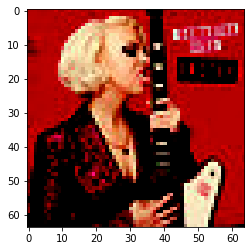

In [ ]:
input_attributes = ["Timbres"]
seed = 42
batch_size = 16

amount = 10_000

train_set = create_sequential_dataset_advanced_padding(train_path, input_attributes, seed=42, length=1024, amount=amount, debug=True, normalized=True)
show_img(train_set[0][1])
test_sample = train_set[0][0]

#dev_set = create_dataset(dev_path, input_attributes)
#test_set = create_dataset(test_path, input_attributes)
amount = len(train_set)


trainloader = DataLoader(train_set, shuffle = True, num_workers = 2, batch_size=batch_size)
#devloader = DataLoader(dev_set, shuffle = True, num_workers = 2, batch_size=batch_size)
#testloader = DataLoader(test_set, shuffle = True, num_workers = 2, batch_size=batch_size)

# Set Device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


# Image CNN class
Output mapped between -1 to 1 with tanh

In [ ]:
class IMG_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(2704, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 128)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x))
    x = self.pool(x)
    x = F.leaky_relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x,1)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x)) 
    x = torch.tanh(self.fc3(x))

    return x


# Deep Image CNN

In [ ]:
class Deep_IMG_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(2704, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 128)
    self.fc4 = nn.Linear(128, 128)
    self.fc5 = nn.Linear(128, 128)

  def forward(self, x):

    x = self.pool(F.leaky_relu(self.conv1(x)))
    x = self.pool(F.leaky_relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    x = F.leaky_relu(self.fc4(x)) 
    x = torch.tanh(self.fc5(x))

    return x


# Sequential Data CNN

In [ ]:
class SEQ_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.dropout = nn.Dropout(p=0.2)
    self.print = False

  def forward(self, x):
    if self.print:
      print("RAW")
      print(x.shape)
      x1 = F.leaky_relu(self.conv1(x))
      print("First")
      print(x1.shape)
      x1 = F.max_pool1d(x1, kernel_size=x1.size(2)).squeeze(2)
      print("First pool")
      print(x1.shape)
      x2 = F.leaky_relu(self.conv2(x))
      print("Second conv")
      print(x2.shape)
      x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
      print("Second pool")
      print(x2.shape)
      x3 = F.leaky_relu(self.conv3(x))
      print("Third conv")
      print(x3.shape)
      x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)
      print("Third pool")
      print(x3.shape)

      out = torch.cat((x1, x2, x3), dim=1)
      out = self.fc1(self.dropout(out))
      out = torch.tanh(out)
    else:
      x1 = F.leaky_relu(self.conv1(x))
      x1 = F.max_pool1d(x1, kernel_size=x1.size(2)).squeeze(2)

      x2 = F.leaky_relu(self.conv2(x))
      x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)

      x3 = F.leaky_relu(self.conv3(x))
      x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)
      out = torch.cat((x1, x2, x3), dim=1)
      out = self.fc1(self.dropout(out))
      out = torch.tanh(out)

    return out


# Deep Sequential Data CNN

In [ ]:
class Deep_SEQ_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv1d(12, 8, 6)
    self.conv2 = nn.Conv1d(12, 8, 12)
    self.conv3 = nn.Conv1d(12, 8, 24)
    self.fc1 = nn.Linear(24, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 128)
    self.dropout = nn.Dropout(p=0.2)
    self.print = False

  def forward(self, x):
    if self.print:
      print("RAW")
      print(x.shape)
      x1 = F.leaky_relu(self.conv1(x))
      print("First")
      print(x1.shape)
      x1 = F.max_pool1d(x1, kernel_size=x1.size(2)).squeeze(2)
      print("First pool")
      print(x1.shape)
      x2 = F.leaky_relu(self.conv2(x))
      print("Second conv")
      print(x2.shape)
      x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
      print("Second pool")
      print(x2.shape)
      x3 = F.leaky_relu(self.conv3(x))
      print("Third conv")
      print(x3.shape)
      x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)
      print("Third pool")
      print(x3.shape)

      out = torch.cat((x1, x2, x3), dim=1)
      out = self.fc1(self.dropout(out))
      out = self.fc2(self.dropout(out))
      out = self.fc3(self.dropout(out))
      out = torch.tanh(out)
    else:
      x1 = F.leaky_relu(self.conv1(x))
      x1 = F.max_pool1d(x1, kernel_size=x1.size(2)).squeeze(2)

      x2 = F.leaky_relu(self.conv2(x))
      x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)

      x3 = F.leaky_relu(self.conv3(x))
      x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)
      out = torch.cat((x1, x2, x3), dim=1)
      out = self.fc1(self.dropout(out))
      out = self.fc2(self.dropout(out))
      out = self.fc3(self.dropout(out))
      out = torch.tanh(out)

    return out


# Loss and Optimizer

In [ ]:
img_cnn = Deep_IMG_CNN().to(device)
seq_cnn = Deep_SEQ_CNN().to(device)

criterion = nn.TripletMarginLoss()
params = list(img_cnn.parameters())
params.extend(seq_cnn.parameters())
optimizer = optim.Adam(params, lr=0.001)

# Training Routine

In [ ]:
img_cnn.train()
seq_cnn.train()

losses = []
epochs = 40

#Change to save checkpoints
enable_checkpoints = True

if enable_checkpoints:
  time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  folder_path = checkpoint_path + "/" + str(time)+ "_SEQ_MODEL_12FOR12_"
  os.mkdir(folder_path)
  os.mkdir(folder_path + "/seq_cnn")
  os.mkdir(folder_path + "/img_cnn")

  with open(folder_path + r"/model_settings.txt", "w") as current_settings:
    current_settings.write(f"ATTRIBUTES: {input_attributes} \nAMOUNT: {amount} \nSEED: {seed} \nBATCH SIZE: {batch_size}")

  with open(folder_path + r"/epoch_losses.csv", "w", encoding="UTF8", newline="") as epoch_losses:
    writer = csv.writer(epoch_losses, delimiter=";")
    writer.writerow(["EPOCH", "LOSS PER SAMPLE"])

for epoch in tqdm(range(epochs)):

  running_loss = 0.0
  for i, data in enumerate(trainloader):

    anchors, positives, negatives = data

    anchors = anchors.to(device)
    anchors = anchors.float()
    positives = positives.to(device)
    positives = positives.float()
    negatives = negatives.to(device)
    negatives = negatives.float()


    optimizer.zero_grad()
    anchors = anchors[:, None]
    negatives = negatives[:, None]
    anchors = seq_cnn(anchors)
    negatives = seq_cnn(negatives)
    positives = img_cnn(positives)

    loss = criterion(anchors, positives, negatives)
    loss.backward()
    optimizer.step()
    # print(running_loss)
    running_loss += loss.item()
  
  print(f"\nEpoch Loss: {running_loss/(amount/batch_size)}")
  losses.append(running_loss/(amount/batch_size))

  if enable_checkpoints:
    torch.save(seq_cnn.state_dict(), f"{folder_path}/seq_cnn/SEQ_CNN_epoch_{epoch}")
    torch.save(img_cnn.state_dict(), f"{folder_path}/img_cnn/IMG_CNN_epoch_{epoch}")

    with open(folder_path + r"/epoch_losses.csv", "a", encoding="UTF8", newline="") as epoch_losses:
      writer = csv.writer(epoch_losses, delimiter=";")
      writer.writerow([epoch, running_loss/(amount/batch_size)])

print("Finished training!")
print(losses)